In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from py_funcs.func_ml import *

warnings.simplefilter('ignore')

sns.set_style("darkgrid")
dark_palette = sns.color_palette("colorblind")
sns.set_palette(dark_palette)
sns.set_color_codes("colorblind")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# Read data

In [2]:
df_ml = pd.read_csv(project_path()+r"/data/target_data/df_ml.csv", index_col=0)

In [3]:
df_explore = df_ml.copy()
df_explore = df_explore[(df_explore["HOUR"] < df_explore["SEPSIS_ONSET_HOUR"]) & 
                        (df_explore["HOUR"] >= df_explore["SEPSIS_ONSET_HOUR"] - 12) &
                        (df_explore["SEPSIS_ONSET_HOUR"] >= 5)]

# Evaluate the best size of hours for ML-Training

In [4]:
accuracy_results = {
    "hour_befor_so" :[],
    "train_accuracy":[],
    "test_accuracy" :[],
    "test_accuracy_1h":[],
    "test_accuracy_2h":[],
    "test_accuracy_4h":[],
    "test_accuracy_6h":[],
    "test_accuracy_8h":[],
    "test_accuracy_10h":[],
    "test_accuracy_12h":[],
}


hours_before_so = [1,2,4,6,8,10,12]

for hour in hours_before_so:
    df_ml_                      = ml_functions.make_df_for_ml(df_ml, hours_before_sepsis_onset=hour, hours_before_sepsis_cutoff=0)
    df_train_ids, df_test_ids   = ml_functions.get_train_test_icustays(df_ml, onset_hour=5, test_size=0.2)

    np.random.seed(42)
    grouped = [df for _, df in df_ml_.groupby('ICUSTAY_ID')]
    np.random.shuffle(grouped)
    shuffled_df_ml = pd.concat(grouped).reset_index(drop=True)

    df_ml_train = shuffled_df_ml.merge(df_train_ids, on=["SEPSIS_ID", "RANDOM_NO_SEPSIS_ID"]) 
    df_ml_test  = shuffled_df_ml.merge(df_test_ids, on=["SEPSIS_ID", "RANDOM_NO_SEPSIS_ID"])

    X_train = df_ml_train.iloc[:, 10:]
    y_train = df_ml_train["SEPSIS_LABEL"]
    X_test = df_ml_test.iloc[:, 10:]
    y_test = df_ml_test["SEPSIS_LABEL"]

    rf      = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=8, n_estimators=500)
    model   = rf.fit(X_train, y_train)

    meta            = df_ml.merge(df_test_ids, on=["SEPSIS_ID", "RANDOM_NO_SEPSIS_ID"]).iloc[:, :10]
    X_test_         = df_ml.merge(df_test_ids, on=["SEPSIS_ID", "RANDOM_NO_SEPSIS_ID"]).iloc[:, 10:]
    y_pred_proba    = model.predict_proba(X_test_)
    df_pred         = pd.concat([meta.reset_index(drop=True), pd.DataFrame(y_pred_proba).reset_index(drop=True)], axis=1)

    temp_accuracy_scores = []
    for hour_ in hours_before_so:
        icu_stay_wise = df_pred[(df_pred["HOUR"] < df_pred["SEPSIS_ONSET_HOUR"] - hour_) & 
                                (df_pred["HOUR"] + (hour_ + 4) >= df_pred["SEPSIS_ONSET_HOUR"])]
        y_pred = np.where(icu_stay_wise.groupby("ICUSTAY_ID")[1].mean() >= 0.5, 1, 0).tolist()
        y_score = icu_stay_wise.groupby("ICUSTAY_ID")[1].mean().to_list()
        y_true = icu_stay_wise.groupby("ICUSTAY_ID")["SEPSIS_LABEL"].max().to_list()
        temp_accuracy_scores.append(accuracy_score(y_true, y_pred))

    accuracy_results["hour_befor_so"].append(hour)
    accuracy_results["train_accuracy"].append(accuracy_score(y_train, model.predict(X_train)))
    accuracy_results["test_accuracy"].append(accuracy_score(y_test, model.predict(X_test)))
    for i, accuracy in enumerate(temp_accuracy_scores):
        key = list(accuracy_results.keys())[3:]
        key = key[i]
        accuracy_results[key].append(accuracy)

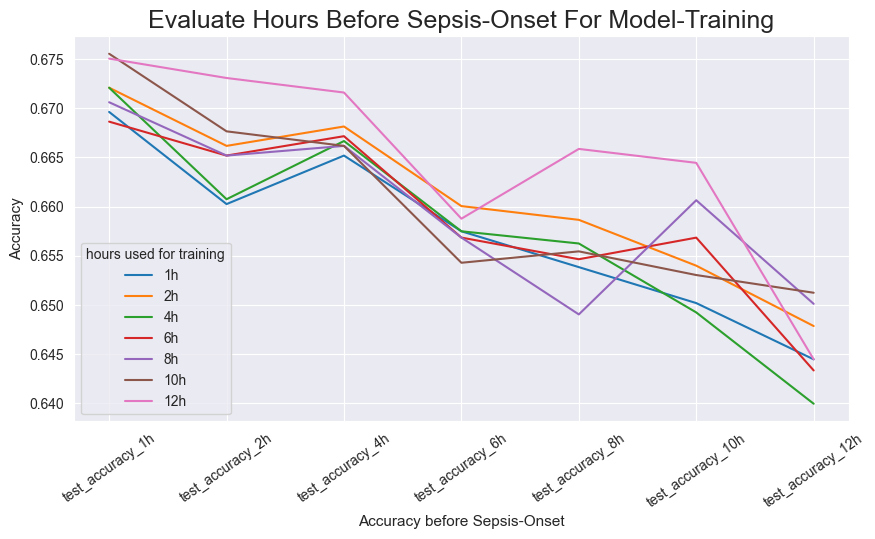

In [5]:
data = pd.DataFrame(accuracy_results)
data.drop(columns=["train_accuracy", "test_accuracy"], inplace=True)
data = data.melt(id_vars="hour_befor_so")

plt.figure(figsize=(10,5))
plt.title("Evaluate Hours Before Sepsis-Onset For Model-Training", fontsize=18)
ax = sns.lineplot(data=data, x="variable", y="value", hue="hour_befor_so", palette="tab10")
handles, labels = ax.get_legend_handles_labels()
new_labels = [str(label) + "h" for label in labels]
ax.legend(handles, new_labels, loc='lower left', title="hours used for training")
plt.xlabel("Accuracy before Sepsis-Onset", fontsize=11)
plt.ylabel("Accuracy", fontsize=11)
plt.xticks(rotation=35)
plt.show()


In [6]:
data = pd.DataFrame(accuracy_results)
pd.DataFrame(data.iloc[data.iloc[:,2:].median(axis=1).idxmax()])

,6
hour_befor_so,12.000000
train_accuracy,0.756767
test_accuracy,0.670343
test_accuracy_1h,0.675049
test_accuracy_2h,0.673077
test_accuracy_4h,0.671598
test_accuracy_6h,0.658771
test_accuracy_8h,0.665865
test_accuracy_10h,0.664449
test_accuracy_12h,0.644470


# Find alpha for L1 regularization (LR, SVM)

In [7]:
X = df_explore.iloc[:, 10:]
y = df_explore['SEPSIS_LABEL']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

alpha_values = np.logspace(-4, 2, 50)

# Initialisierung des Ergebnisspeichers
lr_results = {
    "alpha": [],
    "scores": [],
    "selected_features_with_importance": [] 
}

gkf = GroupKFold(n_splits=5)
groups = df_explore["ICUSTAY_ID"]

for alpha in alpha_values:
    print(f"Running Lasso with alpha={alpha}")
    
    lasso = LassoCV(alphas=[alpha], cv=10, random_state=42, max_iter=1000, n_jobs=-1)
    lasso.fit(X_scaled, y)
    
    selected_features = X.columns[lasso.coef_ != 0]
    
    if len(selected_features) == 0:
        print(f"No features selected at alpha={alpha}. Ending loop.")
        break
    
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_score = cross_val_score(lr_model, X[selected_features], y, cv=gkf, groups=groups, n_jobs=-1).mean()

    lr_results["alpha"].append(alpha)
    lr_results["scores"].append(lr_score)
    feature_dict = dict(zip(selected_features, lasso.coef_[lasso.coef_ != 0]))
    lr_results["selected_features_with_importance"].append(feature_dict)
    
    print(f"LR Score: {lr_score:.4f}, Selected Features: {len(selected_features)}")

Running Lasso with alpha=0.0001
LR Score: 0.5696, Selected Features: 368
Running Lasso with alpha=0.00013257113655901095
LR Score: 0.5747, Selected Features: 343
Running Lasso with alpha=0.00017575106248547912
LR Score: 0.5725, Selected Features: 322
Running Lasso with alpha=0.00023299518105153718
LR Score: 0.5692, Selected Features: 302
Running Lasso with alpha=0.00030888435964774815
LR Score: 0.5760, Selected Features: 275
Running Lasso with alpha=0.00040949150623804275
LR Score: 0.5759, Selected Features: 248
Running Lasso with alpha=0.0005428675439323859
LR Score: 0.5745, Selected Features: 228
Running Lasso with alpha=0.0007196856730011522
LR Score: 0.5744, Selected Features: 209
Running Lasso with alpha=0.0009540954763499944
LR Score: 0.5730, Selected Features: 194
Running Lasso with alpha=0.0012648552168552957
LR Score: 0.5642, Selected Features: 186
Running Lasso with alpha=0.0016768329368110084
LR Score: 0.5857, Selected Features: 174
Running Lasso with alpha=0.002222996482526

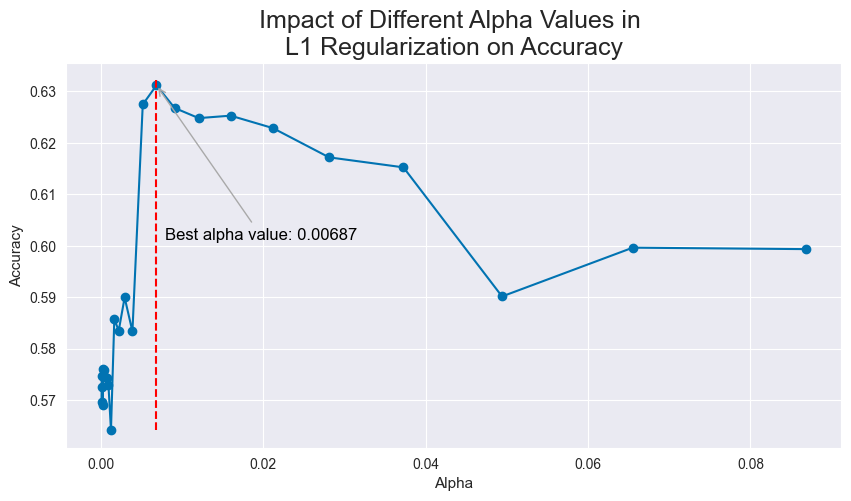

In [8]:
x = lr_results["alpha"]
y = lr_results["scores"]
elbow_point_idx = y.index(max(y))  # Corrected typo: 'ellbow_point' to 'elbow_point_idx'
elbow_point = x[elbow_point_idx]  # Use the index to find the corresponding alpha value

plt.figure(figsize=(10, 5))
plt.plot(x, y, marker='o')  # Added markers for better visibility
plt.title("Impact of Different Alpha Values in \nL1 Regularization on Accuracy", fontsize=18)
plt.vlines(elbow_point, ymin=min(y), ymax=max(y)+0.001, linestyles="dashed", colors="red")
plt.annotate(f"Best alpha value: {round(x[y.index(max(y))], 5)}", 
             xy=(elbow_point, max(y)), 
             xytext=(elbow_point+0.001, max(y) - 0.03),  # Adjusted the annotation position for clarity
             arrowprops=dict(facecolor='darkgrey', edgecolor='darkgrey', arrowstyle="->"),
             fontsize=12, color='black')
plt.ylabel("Accuracy", fontsize=11)  # Capitalized 'Accuracy' for consistency
plt.xlabel("Alpha", fontsize=11)  # Capitalized 'Alpha' for consistency
plt.grid(True)  # Added a grid for better readability
plt.show()


In [9]:
ellbow_point = lr_results["scores"].index(max(lr_results["scores"]))

lf_feature_selection            = pd.DataFrame(list(lr_results["selected_features_with_importance"][ellbow_point].items()), columns=["Feature", "Importance"])
lf_feature_selection["Alpha"]   = [lr_results["alpha"][ellbow_point] for i in range(len(lf_feature_selection))]
lf_feature_selection            .sort_values(by="Importance", inplace=True)
lf_feature_selection            .to_csv(project_path()+r"/data/target_data/lf_feature_selection.csv")

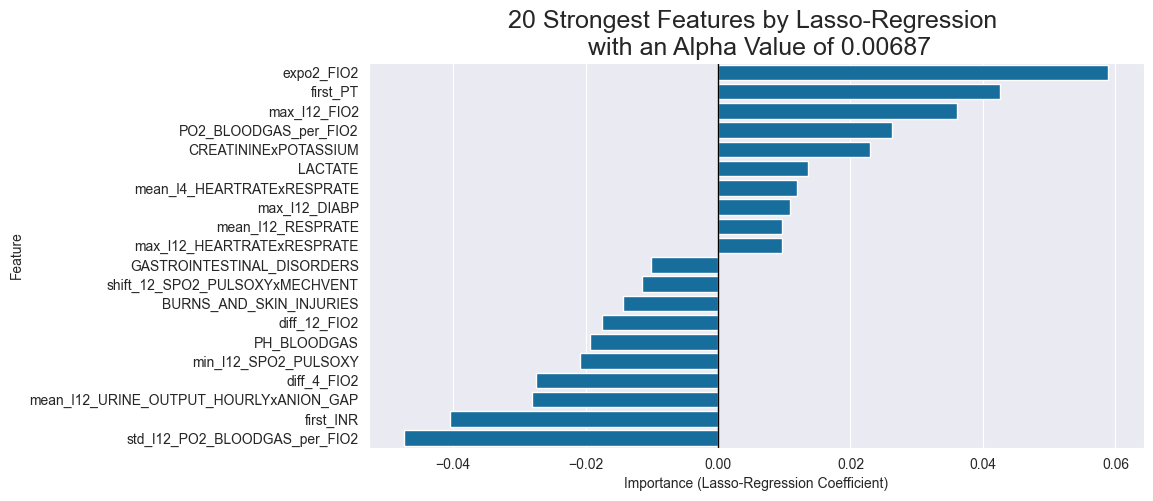

In [10]:
data        = pd.read_csv(project_path()+r"/data/target_data/lf_feature_selection.csv", index_col=0)
data_head   = data.head(10)
data_tail   = data.tail(10)
data        = pd.concat([data_head, data_tail])
data = data.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10,5))
plt.title("20 Strongest Features by Lasso-Regression \n with an Alpha Value of 0.00687", fontsize=18)
sns.barplot(data=data, y="Feature", x="Importance")
plt.axvline(x=0, color='black', linewidth=1)
plt.xlabel("Importance (Lasso-Regression Coefficient)")
plt.show()

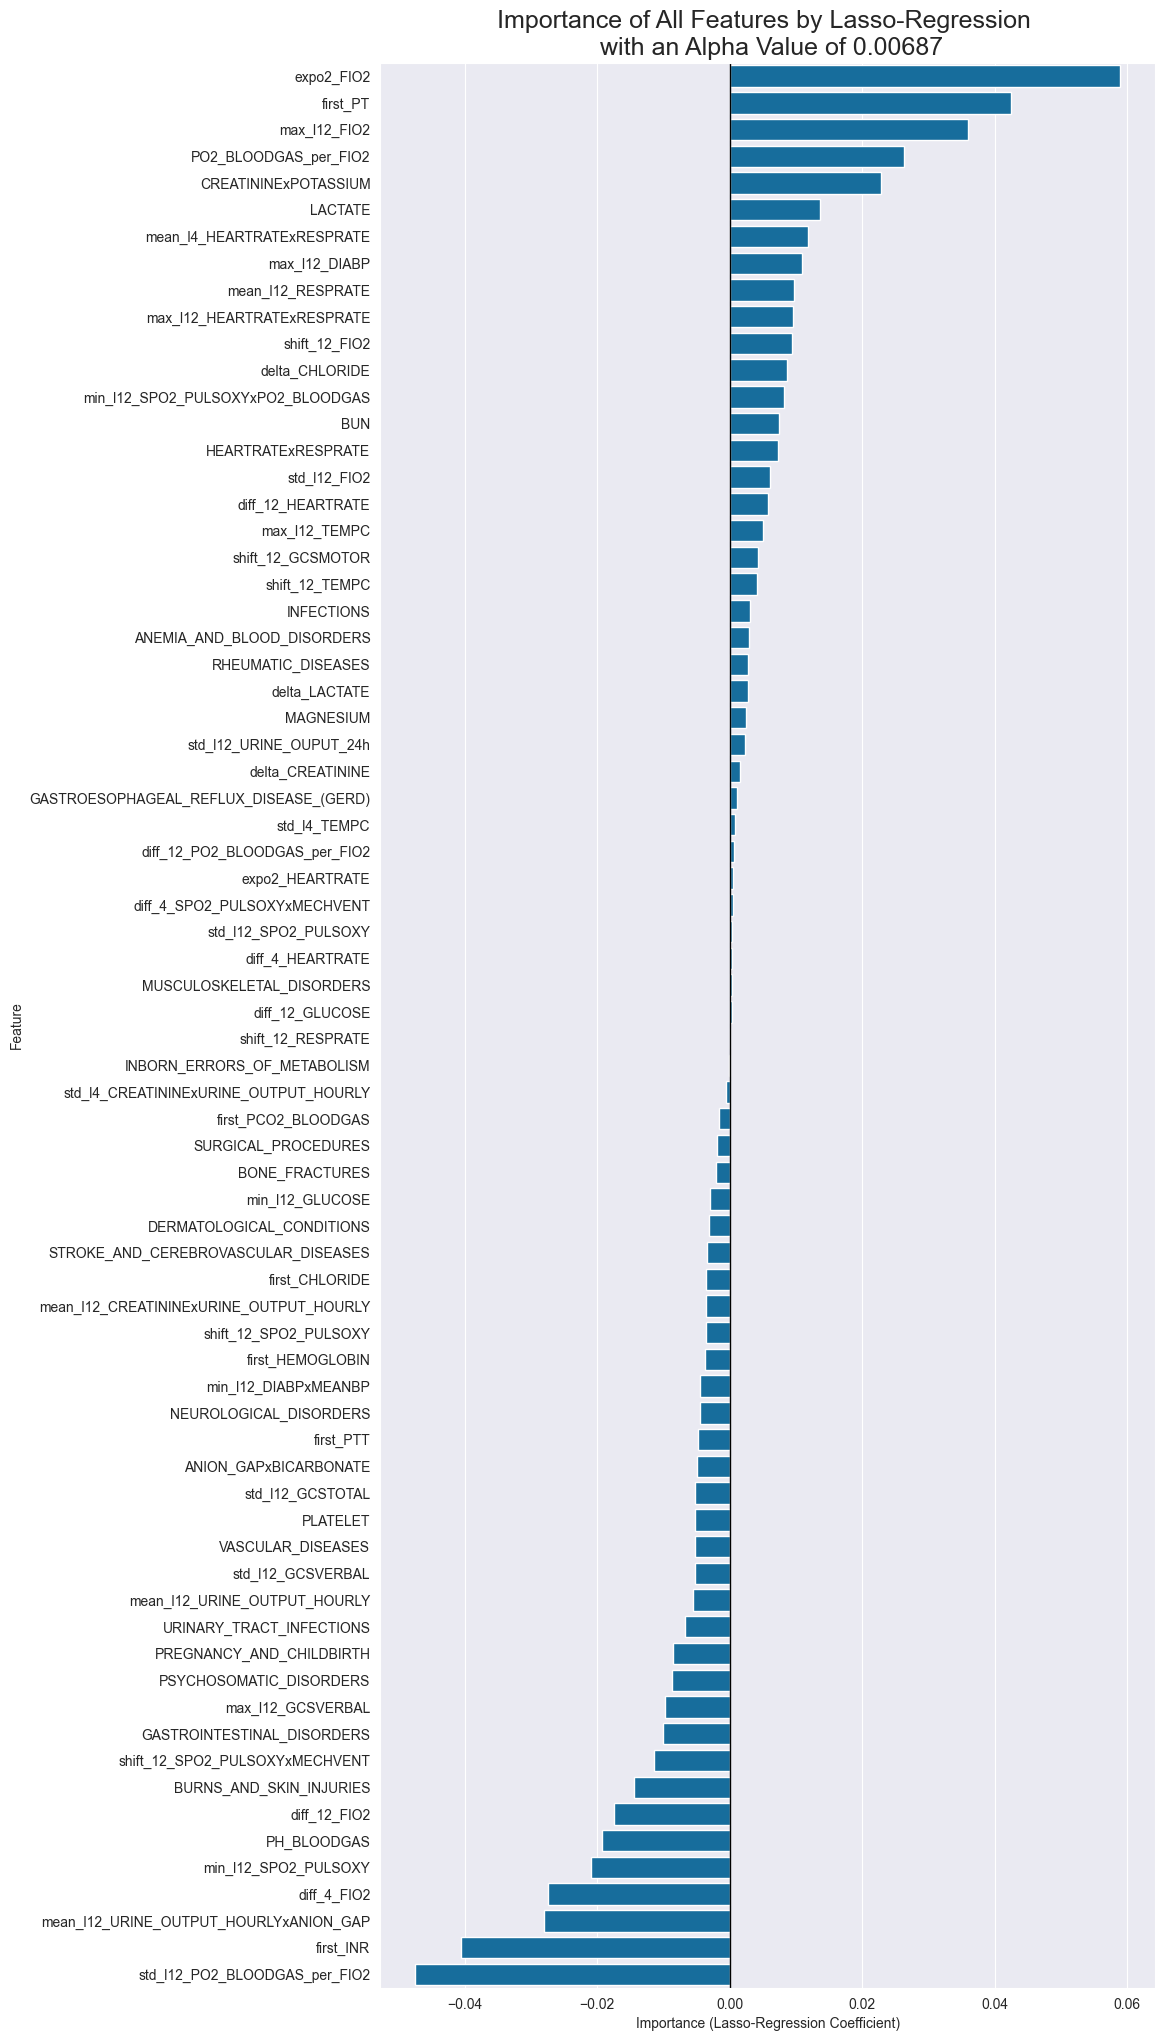

In [11]:
data        = pd.read_csv(project_path()+r"/data/target_data/lf_feature_selection.csv", index_col=0)
data = data.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10,25))
plt.title("Importance of All Features by Lasso-Regression \n with an Alpha Value of 0.00687", fontsize=18)
sns.barplot(data=data, y="Feature", x="Importance")
plt.axvline(x=0, color='black', linewidth=1)
plt.xlabel("Importance (Lasso-Regression Coefficient)")
plt.show()

# Find n features for (RF, XGB)

In [13]:
X = df_explore.iloc[:, 10:]
y = df_explore['SEPSIS_LABEL']

gkf     = GroupKFold(n_splits=20)
groups  = df_explore["ICUSTAY_ID"]

rf = RandomForestClassifier(n_jobs=-1, random_state=42)
rf.fit(X=X, y=y)

feature_importances = rf.feature_importances_

sorted_indices              = np.argsort(feature_importances)[::-1]
sorted_feature_importances  = feature_importances[sorted_indices]
sorted_features             = X.columns[sorted_indices]

rf_results = {
    "n_features":[],
    "scores":[],
    "selected_features_list":[],
}

for n in [10,15,20,25,30,35,40,45,50,60,70,80,90,100,150,200,250,300,350,400]:
    print(f"Running RF with n features: {n}")
    sub_features    = sorted_features[:n]
    X_sub           = X[sub_features]
    rf              = RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=9)
    rf              .fit(X=X_sub, y=y)
    rf_score        = cross_val_score(estimator=rf, X=X_sub, y=y, groups=groups, cv=gkf).mean()
    rf_results["n_features"].append(n)
    rf_results["scores"].append(rf_score)
    rf_results["selected_features_list"].append(sub_features)
    print(f"RF Score: {rf_score:.4f}, Selected Features: {n}")

Running RF with n features: 10
RF Score: 0.6286, Selected Features: 10
Running RF with n features: 15
RF Score: 0.6382, Selected Features: 15
Running RF with n features: 20
RF Score: 0.6448, Selected Features: 20
Running RF with n features: 25
RF Score: 0.6451, Selected Features: 25
Running RF with n features: 30
RF Score: 0.6461, Selected Features: 30
Running RF with n features: 35
RF Score: 0.6502, Selected Features: 35
Running RF with n features: 40
RF Score: 0.6521, Selected Features: 40
Running RF with n features: 45
RF Score: 0.6539, Selected Features: 45
Running RF with n features: 50
RF Score: 0.6582, Selected Features: 50
Running RF with n features: 60
RF Score: 0.6590, Selected Features: 60
Running RF with n features: 70
RF Score: 0.6567, Selected Features: 70
Running RF with n features: 80
RF Score: 0.6592, Selected Features: 80
Running RF with n features: 90
RF Score: 0.6601, Selected Features: 90
Running RF with n features: 100
RF Score: 0.6628, Selected Features: 100
Runn

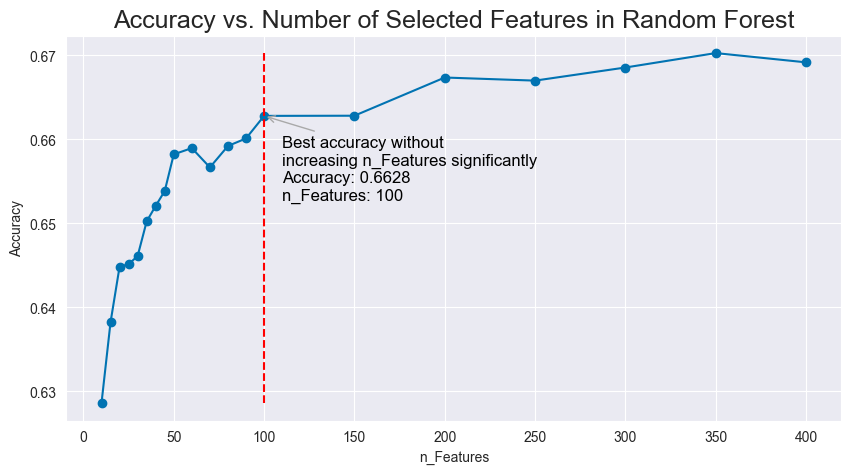

In [26]:
x = rf_results["n_features"]
y = rf_results["scores"]

plt.figure(figsize=(10, 5))
plt.plot(x,y, marker='o')
plt.title("Accuracy vs. Number of Selected Features in Random Forest", fontsize=18)
n_features = 100
plt.vlines(n_features, ymin=min(y), ymax=max(y), linestyles="dashed", colors="red")
plt.annotate(f"Best accuracy without\nincreasing n_Features significantly\
             \nAccuracy: {round(y[x.index(n_features)],4)}\
             \nn_Features: {n_features}", 
             xy=(n_features, y[x.index(n_features)]), 
             xytext=(n_features+10, y[x.index(n_features)]-0.01),  # Adjusted the annotation position for clarity
             arrowprops=dict(facecolor='darkgrey', edgecolor='darkgrey', arrowstyle="->"),
             fontsize=12, color='black')
plt.xlabel("n_Features")
plt.ylabel("Accuracy")
plt.show()

In [27]:
n_features              = 100
ellbow_point            = x.index(n_features)
rf_feature_selection    = pd.DataFrame([rf_results["selected_features_list"][ellbow_point][:n_features], sorted_feature_importances[:n_features]]).T
rf_feature_selection    .rename(columns={0:"Feature", 1:"Importance"}, inplace=True)
rf_feature_selection    .to_csv(project_path()+r"/data/target_data/rf_feature_selection.csv")

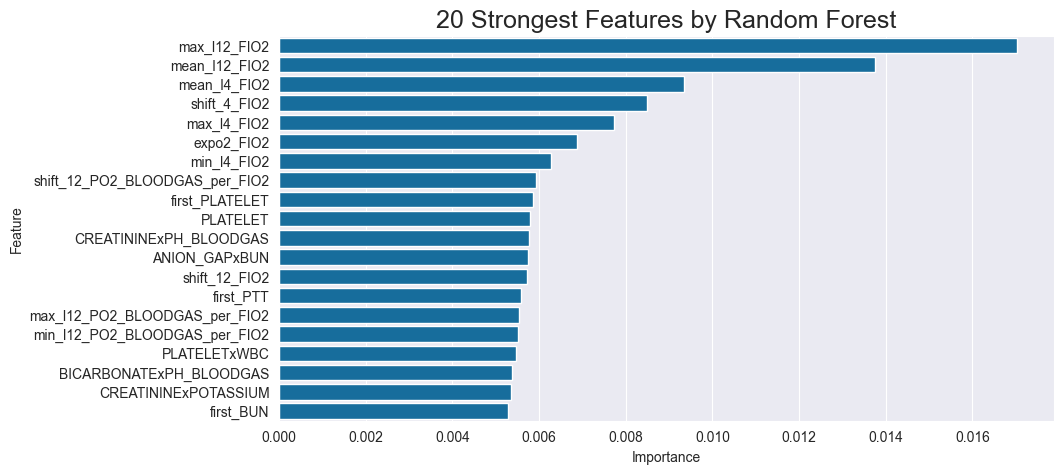

In [29]:
data = pd.read_csv(project_path()+r"/data/target_data/rf_feature_selection.csv", index_col=0)
data.sort_values(by="Importance", ascending=True)
data = data.head(20)
plt.figure(figsize=(10,5))
plt.title("20 Strongest Features by Random Forest", fontsize=18)
sns.barplot(data, y="Feature", x="Importance")
plt.show()

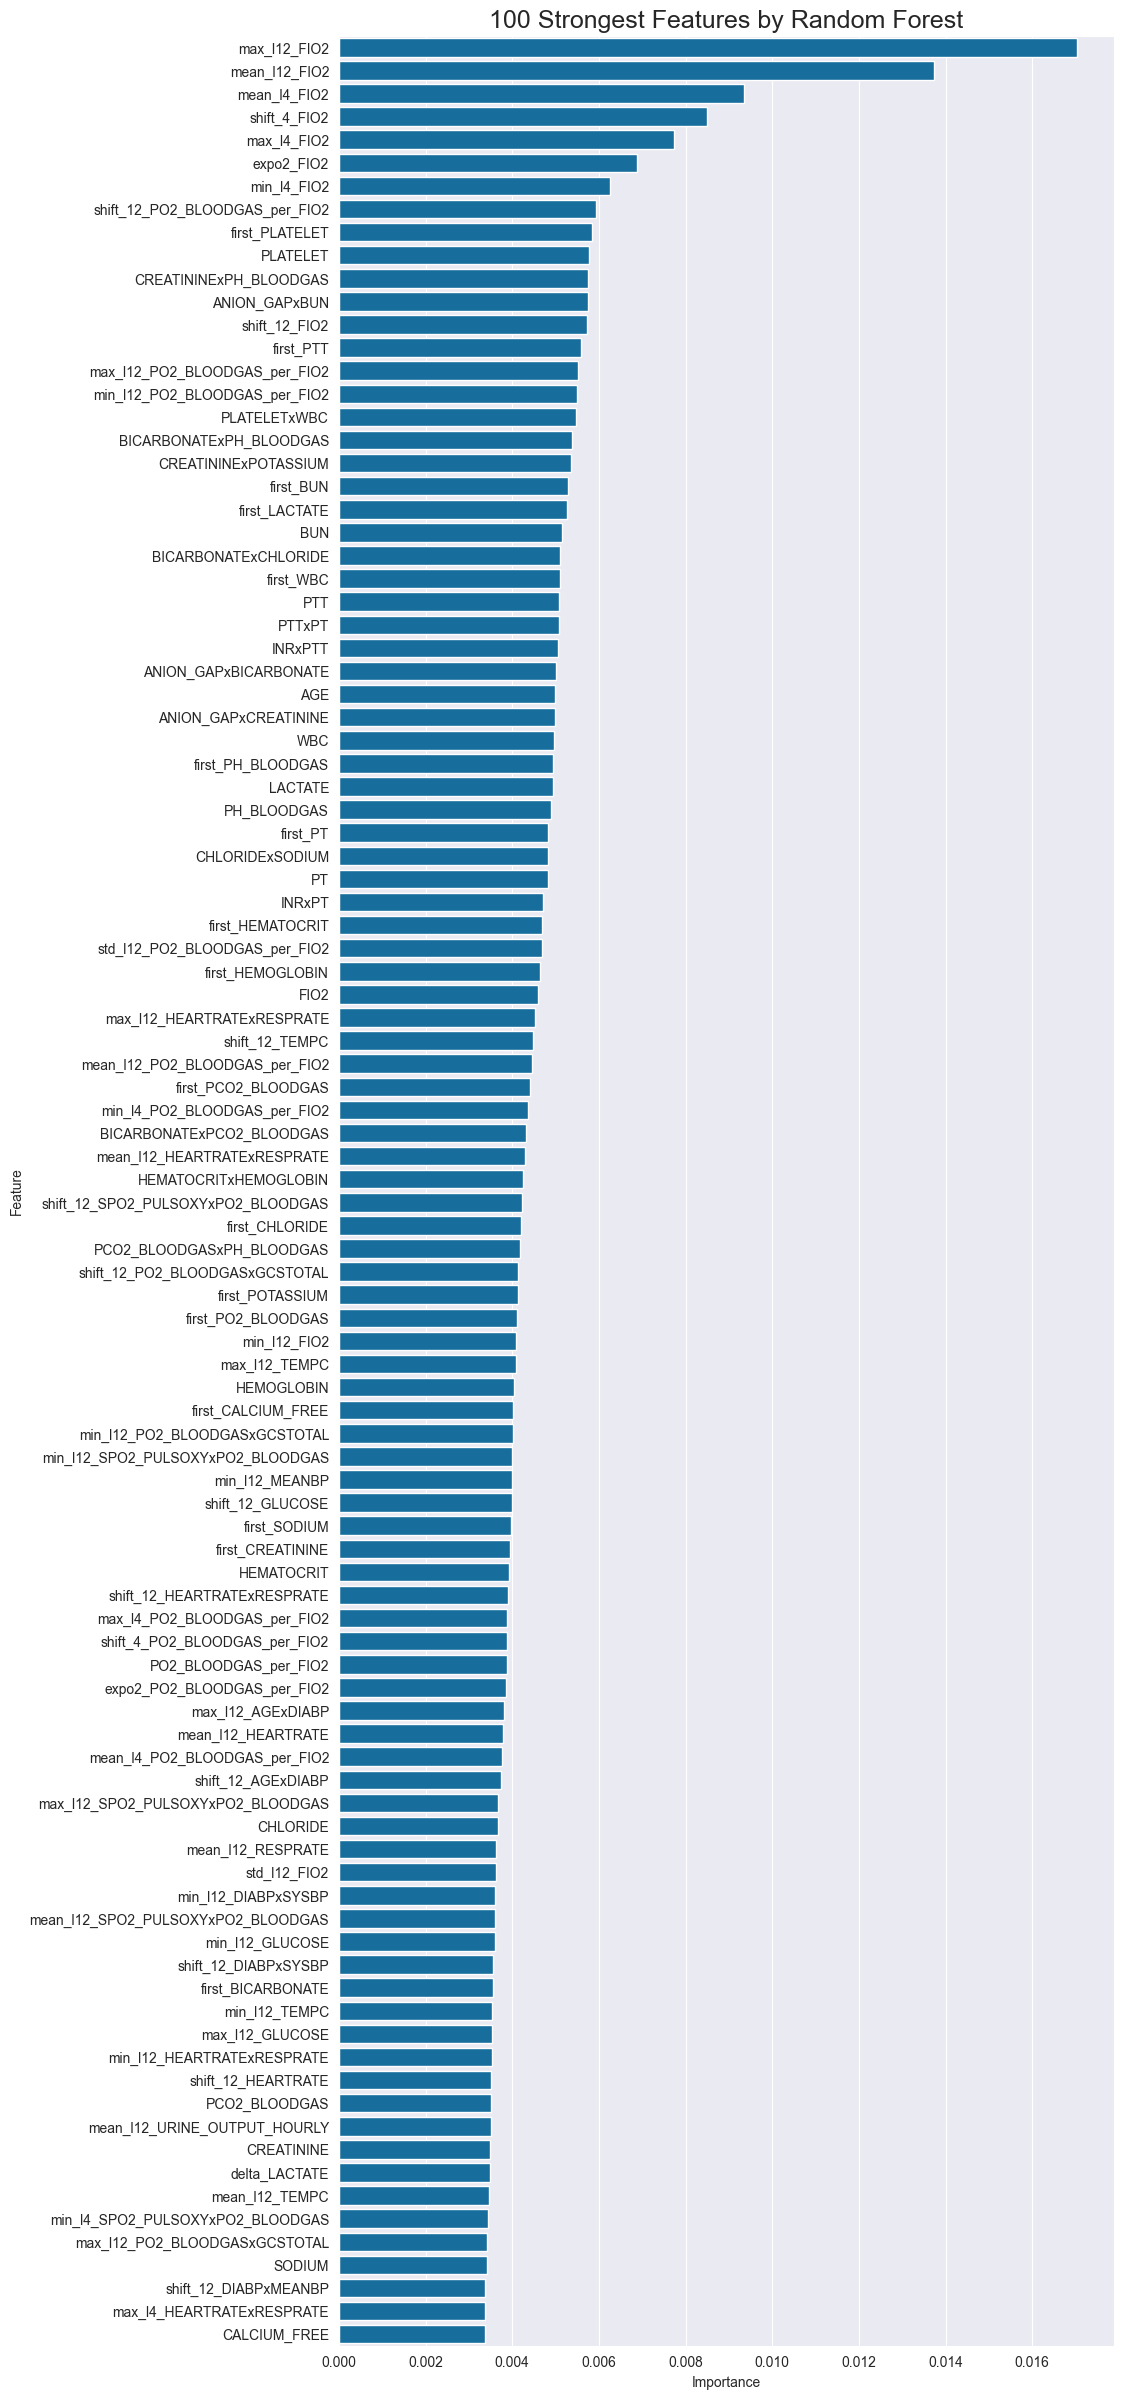

In [31]:
data = pd.read_csv(project_path()+r"/data/target_data/rf_feature_selection.csv", index_col=0)
data.sort_values(by="Importance", ascending=True)
plt.figure(figsize=(10,30))
plt.title("100 Strongest Features by Random Forest", fontsize=18)
sns.barplot(data, y="Feature", x="Importance")
plt.show()